##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Inspect and debug decision forest models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/advanced_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/advanced_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/advanced_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/advanced_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


In this colab, you will learn how to inspect and create the structure of a model directly. We assume you are familiar with the concepts introduced in the
[beginner](beginner_colab.ipynb) and [intermediate](intermediate_colab.ipynb)
colabs.

In this colab, you will:

1.  Train a Random Forest model and access its structure programmatically.

1.  Create a Random Forest model by hand and use it as a classical model.

## Setup

In [2]:
# Install TensorFlow Decision Forests.
!pip install tensorflow_decision_forests

# Use wurlitzer to show the training logs.
!pip install wurlitzer

  Using cached tensorflow_decision_forests-1.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached wurlitzer-3.0.3-py3-none-any.whl.metadata (1.9 kB)


Using cached tensorflow_decision_forests-1.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.5 MB)


Using cached wurlitzer-3.0.3-py3-none-any.whl (7.3 kB)


In [3]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import math
import collections

The hidden code cell limits the output height in colab.

In [4]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Train a simple Random Forest

We train a Random Forest like in the [beginner colab](beginner_colab.ipynb):

In [5]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Show the first three examples.
print(dataset_df.head(3))

# Convert the pandas dataframe into a tf dataset.
dataset_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="species")

# Train the Random Forest
model = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)
model.fit(x=dataset_tf)

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  


Use /tmpfs/tmp/tmpadwizz7x as temporary training directory


Reading training dataset...


Training dataset read in 0:00:03.574049. Found 344 examples.


Training model...


Model trained in 0:00:00.092571


Compiling model...


[INFO 24-04-20 11:24:50.3886 UTC kernel.cc:1233] Loading model from path /tmpfs/tmp/tmpadwizz7x/model/ with prefix 59499fe5fa654879
[INFO 24-04-20 11:24:50.4047 UTC decision_forest.cc:734] Model loaded with 300 root(s), 5080 node(s), and 7 input feature(s).
[INFO 24-04-20 11:24:50.4047 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-04-20 11:24:50.4048 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


Note the `compute_oob_variable_importances=True`
hyper-parameter in the model constructor. This option computes the Out-of-bag (OOB)
variable importance during training. This is a popular
[permutation variable importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) for Random Forest models.

Computing the OOB Variable importance does not impact the final model, it will slow the training on large datasets.

Check the model summary:

In [6]:
%set_cell_height 300

model.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


Total params: 1 (1.00 Byte)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 1 (1.00 Byte)


_________________________________________________________________


Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "flipper_length_mm"  0.440513 ################
    2.    "bill_length_mm"  0.438028 ###############
    3.     "bill_depth_mm"  0.299751 #####
    4.            "island"  0.295079 #####
    5.       "body_mass_g"  0.256534 ##
    6.               "sex"  0.225708 
    7.              "year"  0.224020 

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1.    "bill_length_mm"  0.151163 ################
    2.            "island"  0.008721 #
    3.     "bill_depth_mm"  0.000000 
    4.       "body_mass_g"  0.000000 
    5.               "sex"  0.000000 
    6.              "year"  0.000000 
    7. "flipper_length_mm" -0.002907 

Variable Importance: MEAN_DECREASE_IN_AP_1_VS_OTHERS:
    1.    "bill_length_mm"  0.083305 ################
    2.            "island"  0.007

Note the multiple variable importances with name `MEAN_DECREASE_IN_*`.

## Plotting the model

Next, plot the model.

A Random Forest is a large model (this model has 300 trees and ~5k nodes; see the summary above). Therefore, only plot the first tree, and limit the nodes to depth 3.

In [7]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

## Inspect the model structure

The model structure and meta-data is
available through the **inspector** created by `make_inspector()`.

**Note:** Depending on the learning algorithm and hyper-parameters, the
inspector will expose different specialized attributes. For examples, the
`winner_take_all` field is specific to Random Forest models.

In [8]:
inspector = model.make_inspector()

For our model, the available inspector fields are:

In [9]:
[field for field in dir(inspector) if not field.startswith("_")]

['MODEL_NAME',
 'dataspec',
 'directory',
 'evaluation',
 'export_to_tensorboard',
 'extract_all_trees',
 'extract_tree',
 'features',
 'file_prefix',
 'header',
 'iterate_on_nodes',
 'label',
 'label_classes',
 'metadata',
 'model_type',
 'num_trees',
 'objective',
 'specialized_header',
 'task',
 'training_logs',
 'tuning_logs',
 'variable_importances',
 'winner_take_all_inference']

Remember to see [the API-reference](https://tensorflow.org/decision_forests/api_docs/python/tfdf/inspector/AbstractInspector) or use `?` for the builtin documentation.

In [10]:
?inspector.model_type

Some of the model meta-data:

In [11]:
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

Model type: RANDOM_FOREST
Number of trees: 300
Objective: Classification(label=__LABEL, class=None, num_classes=3)
Input features: ["bill_depth_mm" (1; #1), "bill_length_mm" (1; #2), "body_mass_g" (1; #3), "flipper_length_mm" (1; #4), "island" (4; #5), "sex" (4; #6), "year" (1; #7)]


`evaluate()` is the evaluation of the model computed during training. The dataset used for this evaluation depends on the algorithm. For example, it can be the validation dataset or the out-of-bag-dataset .

**Note:** While computed during training, `evaluate()` is never an evaluation on the
training dataset.

In [12]:
inspector.evaluation()

Evaluation(num_examples=344, accuracy=0.9767441860465116, loss=0.06894904488784283, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

The variable importances are:

In [13]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_DECREASE_IN_PRAUC_3_VS_OTHERS
	 MEAN_DECREASE_IN_PRAUC_1_VS_OTHERS
	 INV_MEAN_MIN_DEPTH
	 MEAN_DECREASE_IN_AUC_1_VS_OTHERS
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 MEAN_DECREASE_IN_AUC_3_VS_OTHERS
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 MEAN_DECREASE_IN_AP_1_VS_OTHERS
	 NUM_AS_ROOT
	 NUM_NODES
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 MEAN_DECREASE_IN_ACCURACY
	 SUM_SCORE
	 MEAN_DECREASE_IN_AP_3_VS_OTHERS


Different variable importances have different semantics. For example, a feature
with a **mean decrease in auc** of `0.05` means that removing this feature from
the training dataset would reduce/hurt the AUC by 5%.

In [14]:
# Mean decrease in AUC of the class 1 vs the others.
inspector.variable_importances()["MEAN_DECREASE_IN_AUC_1_VS_OTHERS"]

[("bill_length_mm" (1; #2), 0.0713061951754389),
 ("island" (4; #5), 0.007298519736842035),
 ("flipper_length_mm" (1; #4), 0.004505893640351366),
 ("bill_depth_mm" (1; #1), 0.0021244517543865804),
 ("body_mass_g" (1; #3), 0.0005482456140351033),
 ("sex" (4; #6), 0.00047971491228060437),
 ("year" (1; #7), 0.0)]

Plot the variable importances from the inspector using Matplotlib

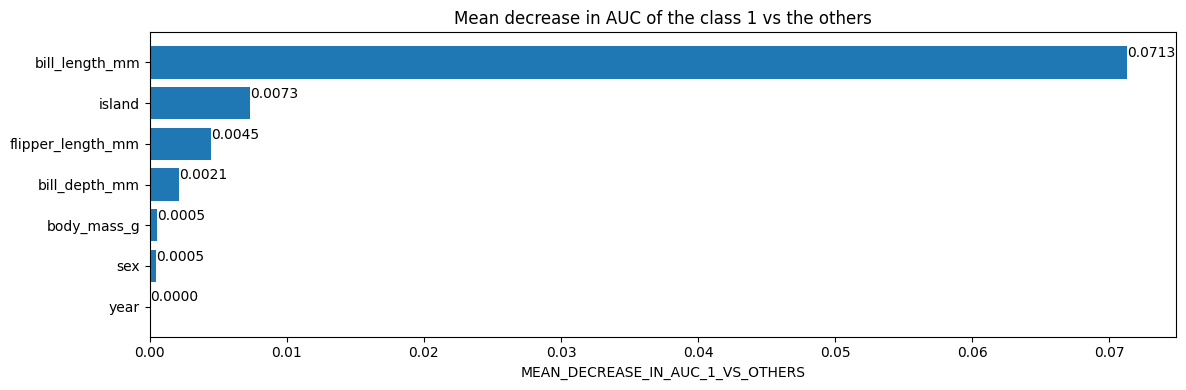

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "MEAN_DECREASE_IN_AUC_1_VS_OTHERS"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("Mean decrease in AUC of the class 1 vs the others")
plt.tight_layout()
plt.show()

Finally, access the actual tree structure:

In [16]:
inspector.extract_tree(tree_idx=0)

Tree(root=NonLeafNode(condition=(bill_length_mm >= 43.25; miss=True, score=0.5482327342033386), pos_child=NonLeafNode(condition=(island in ['Biscoe']; miss=True, score=0.6515106558799744), pos_child=NonLeafNode(condition=(bill_depth_mm >= 17.225584030151367; miss=False, score=0.027205035090446472), pos_child=LeafNode(value=ProbabilityValue([0.16666666666666666, 0.0, 0.8333333333333334],n=6.0), idx=7), neg_child=LeafNode(value=ProbabilityValue([0.0, 0.0, 1.0],n=104.0), idx=6), value=ProbabilityValue([0.00909090909090909, 0.0, 0.990909090909091],n=110.0)), neg_child=LeafNode(value=ProbabilityValue([0.0, 1.0, 0.0],n=61.0), idx=5), value=ProbabilityValue([0.005847953216374269, 0.3567251461988304, 0.6374269005847953],n=171.0)), neg_child=NonLeafNode(condition=(bill_depth_mm >= 15.100000381469727; miss=True, score=0.150658518075943), pos_child=NonLeafNode(condition=(flipper_length_mm >= 187.5; miss=True, score=0.036139510571956635), pos_child=LeafNode(value=ProbabilityValue([1.0, 0.0, 0.0],n

Extracting a tree is not efficient. If speed is important, the model inspection can be done with the `iterate_on_nodes()` method instead. This method is a Depth First Pre-order traversals iterator on all the nodes of the model.

**Note:** `extract_tree()` is implemented using `iterate_on_nodes()`.

For following example computes how many times each feature is used (this is a
kind of structural variable importance):

In [17]:
# number_of_use[F] will be the number of node using feature F in its condition.
number_of_use = collections.defaultdict(lambda: 0)

# Iterate over all the nodes in a Depth First Pre-order traversals.
for node_iter in inspector.iterate_on_nodes():

  if not isinstance(node_iter.node, tfdf.py_tree.node.NonLeafNode):
    # Skip the leaf nodes
    continue

  # Iterate over all the features used in the condition.
  # By default, models are "oblique" i.e. each node tests a single feature.
  for feature in node_iter.node.condition.features():
    number_of_use[feature] += 1

print("Number of condition nodes per features:")
for feature, count in number_of_use.items():
  print("\t", feature.name, ":", count)

Number of condition nodes per features:
	 bill_length_mm : 778
	 bill_depth_mm : 463
	 flipper_length_mm : 414
	 island : 342
	 body_mass_g : 338
	 year : 19
	 sex : 36


## Creating a model by hand

In this section you will create a small Random Forest model by hand. To make it
extra easy, the model will only contain one simple tree:

```
3 label classes: Red, blue and green.
2 features: f1 (numerical) and f2 (string categorical)

f1>=1.5
    ├─(pos)─ f2 in ["cat","dog"]
    │         ├─(pos)─ value: [0.8, 0.1, 0.1]
    │         └─(neg)─ value: [0.1, 0.8, 0.1]
    └─(neg)─ value: [0.1, 0.1, 0.8]
```

In [18]:
# Create the model builder
builder = tfdf.builder.RandomForestBuilder(
    path="/tmp/manual_model",
    objective=tfdf.py_tree.objective.ClassificationObjective(
        label="color", classes=["red", "blue", "green"]))

Each tree is added one by one.

**Note:** The tree object (`tfdf.py_tree.tree.Tree`) is the same as the one returned by `extract_tree()` in the previous section.

In [19]:
# So alias
Tree = tfdf.py_tree.tree.Tree
SimpleColumnSpec = tfdf.py_tree.dataspec.SimpleColumnSpec
ColumnType = tfdf.py_tree.dataspec.ColumnType
# Nodes
NonLeafNode = tfdf.py_tree.node.NonLeafNode
LeafNode = tfdf.py_tree.node.LeafNode
# Conditions
NumericalHigherThanCondition = tfdf.py_tree.condition.NumericalHigherThanCondition
CategoricalIsInCondition = tfdf.py_tree.condition.CategoricalIsInCondition
# Leaf values
ProbabilityValue = tfdf.py_tree.value.ProbabilityValue

builder.add_tree(
    Tree(
        NonLeafNode(
            condition=NumericalHigherThanCondition(
                feature=SimpleColumnSpec(name="f1", type=ColumnType.NUMERICAL),
                threshold=1.5,
                missing_evaluation=False),
            pos_child=NonLeafNode(
                condition=CategoricalIsInCondition(
                    feature=SimpleColumnSpec(name="f2",type=ColumnType.CATEGORICAL),
                    mask=["cat", "dog"],
                    missing_evaluation=False),
                pos_child=LeafNode(value=ProbabilityValue(probability=[0.8, 0.1, 0.1], num_examples=10)),
                neg_child=LeafNode(value=ProbabilityValue(probability=[0.1, 0.8, 0.1], num_examples=20))),
            neg_child=LeafNode(value=ProbabilityValue(probability=[0.1, 0.1, 0.8], num_examples=30)))))

Conclude the tree writing

In [20]:
builder.close()

[INFO 24-04-20 11:24:54.9480 UTC kernel.cc:1233] Loading model from path /tmp/manual_model/tmp/ with prefix f938aac6d7ed44f5
[INFO 24-04-20 11:24:54.9483 UTC decision_forest.cc:734] Model loaded with 1 root(s), 5 node(s), and 2 input feature(s).
[INFO 24-04-20 11:24:54.9483 UTC kernel.cc:1061] Use fast generic engine


INFO:tensorflow:Assets written to: /tmp/manual_model/assets


INFO:tensorflow:Assets written to: /tmp/manual_model/assets


Now you can open the model as a regular keras model, and make predictions:

In [21]:
manual_model = tf_keras.models.load_model("/tmp/manual_model")

[INFO 24-04-20 11:24:56.1029 UTC kernel.cc:1233] Loading model from path /tmp/manual_model/assets/ with prefix f938aac6d7ed44f5
[INFO 24-04-20 11:24:56.1032 UTC decision_forest.cc:734] Model loaded with 1 root(s), 5 node(s), and 2 input feature(s).
[INFO 24-04-20 11:24:56.1032 UTC kernel.cc:1061] Use fast generic engine


In [22]:
examples = tf.data.Dataset.from_tensor_slices({
        "f1": [1.0, 2.0, 3.0],
        "f2": ["cat", "cat", "bird"]
    }).batch(2)

predictions = manual_model.predict(examples)

print("predictions:\n",predictions)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 1s 3ms/step


predictions:
 [[0.1 0.1 0.8]
 [0.8 0.1 0.1]
 [0.1 0.8 0.1]]


Access the structure:

**Note:** Because the model is serialized-and-deserialized, you need to use an alternative but equivalent form.

In [23]:
yggdrasil_model_path = manual_model.yggdrasil_model_path_tensor().numpy().decode("utf-8")
print("yggdrasil_model_path:",yggdrasil_model_path)

inspector = tfdf.inspector.make_inspector(yggdrasil_model_path)
print("Input features:", inspector.features())

yggdrasil_model_path: /tmp/manual_model/assets/
Input features: ["f1" (1; #1), "f2" (4; #2)]


And of course, you can plot this manually constructed model:

In [24]:
tfdf.model_plotter.plot_model_in_colab(manual_model)